# Data Processing
## create author to coauthor edgelist

import dataset CSV as Pandas DataFrame object

In [2]:
import pandas as pd, itertools

covidAuthorData = pd.read_csv('datasetForCovidAuthorConnectivityGraph.csv')

print(len(covidAuthorData))
covidAuthorData = covidAuthorData.iloc[: , 1:]
display(covidAuthorData)

300644


,Author ID,Full Name,First Name,Middle Name,Last Name,Country,Covid-19 Publications,Other Coronavirus Publications,Total Publications on Coronavirus,betweenness,centrality
0,88687508,"Antinori, A",A,NaN,Antinori,Italy,32950740,NaN,1,0.000000,0.180207
1,88673946,"Vivaldi, Caterina",Caterina,NaN,Vivaldi,Italy,33060148,NaN,1,0.000000,0.169635
2,88666710,"van de Veerdonk, Frank",Frank,NaN,van de Veerdonk,Netherlands,32876697,NaN,1,0.000000,0.194202
3,88642229,"Gupta, Kavita",Kavita,NaN,Gupta,India,33085120,NaN,1,0.000000,0.511628
4,88639284,"Li, Philip",Philip,NaN,Li,China,33026775,NaN,1,0.000000,0.124367
...,...,...,...,...,...,...,...,...,...,...,...
300639,88698228,"Abou-Samra, Abdul-Badi",Abdul-Badi,NaN,Abou-Samra,Qatar,32919838;32949777;33033033;33126120,NaN,4,0.000000,0.114880
300640,88698239,"Ganesh, Aravind",Aravind,NaN,Ganesh,Canada,32817352;33128573,NaN,2,58193.903170,0.152032
300641,88662237,"Heaton, Nicholas",Nicholas,S,Heaton,United States,32353252;32843534;33128895,NaN,3,12429.000000,0.177032
300642,88698398,"Andr�, Nicolas",Nicolas,NaN,Andr�,France,32383827;32618416;32893961;33129040,NaN,4,706.150465,0.177841


iterate through author dataset to create publication dataset

In [3]:
publicationDictionary = {}
skipCounter_noCovid19Pub = 0

#for index,row in covidAuthorData.head(20000).iterrows(): #this is for processing a small sample of rows
for index, row in covidAuthorData.iterrows(): #iterate through author entries in CSV
    currentRowPublicationList = str(row["Covid-19 Publications"]).split(';') #split multiple values in the Covid Publications column
    for publicationId in currentRowPublicationList: #iterate through the Covid-19 Publications
        if publicationId == 'nan': #skip author rows with no COVID-19 publications
            skipCounter_noCovid19Pub += 1
        if publicationId != 'nan': #add other publicatoins 
            if publicationId not in publicationDictionary.keys(): 
                publicationDictionary[publicationId] = {} #add PubIds to PublicationDictionary (empty values)
            publicationDictionary[publicationId][str(row["Author ID"])] = {'Name': row["Full Name"], 'Country' : row["Country"], 'PubNum': row["Total Publications on Coronavirus"]}
            # create nested Dictionary for authors of publications

#create DataFrame from Pub Dictionary
datasetOfEachPublicationAuthors = pd.DataFrame({'Publication': publicationDictionary.keys(), 'Authors': publicationDictionary.values()})
#create CSV from DataFrame if wishing to store this Data
#datasetOfEachPublicationAuthors.to_csv('datasetOfEachPublicationAuthorsWithMoreInfo.csv')

display(datasetOfEachPublicationAuthors)

,Publication,Authors
0,32950740,"{'88687508': {'Name': 'Antinori, A', 'Country'..."
1,33060148,"{'88673946': {'Name': 'Vivaldi, Caterina', 'Co..."
2,32876697,"{'88666710': {'Name': 'van de Veerdonk, Frank'..."
3,33085120,"{'88642229': {'Name': 'Gupta, Kavita', 'Countr..."
4,33026775,"{'88639284': {'Name': 'Li, Philip', 'Country':..."
...,...,...
66396,33121609,"{'88694864': {'Name': 'Mark, Anita', 'Country'..."
66397,32997860,"{'88695250': {'Name': 'Magoon, Rohan', 'Countr..."
66398,33012159,"{'88695250': {'Name': 'Magoon, Rohan', 'Countr..."
66399,33128606,"{'88695250': {'Name': 'Magoon, Rohan', 'Countr..."


iterate through publication dataset to create edgelist of author to coauthor 

In [8]:
coAuthorDictionary = {}
coAuthorList = []

noCollaboratorCounter = 0

#print(len(publicationDictionary))
for publicationId in publicationDictionary.keys(): # iterate through publications in pub Dictionary
    authorIdList = publicationDictionary[publicationId] # extract dictionary of authors for each Pub in loop
    
    if len(authorIdList.keys()) == 1:
            noCollaboratorCounter += 1
            pass
    else:
        for authorId in authorIdList.keys(): # iterate through each author in the dictionary of authors (for each Pub)
            country = authorIdList[authorId].get('Country') # extract country of each author from authorDictionary (for each Pub)
            name = authorIdList[authorId].get('Name') # get full name of each author from authorDictionary (for each Pub)
            pubnum = authorIdList[authorId].get('PubNum')
            authornum = len(authorIdList.keys()) # number of a paper's coauthors, i.e. the team size (edge feature/attribute)


            # as we cycle through pubs and their authors, for each author of each pub, compare to every one of authors of the same pub
                # nested loop
            for coAuthorId in authorIdList:
                coAuthor_innerDict = {}
                if(authorId!=coAuthorId): #make sure not comparing author to themselves
                    coAuthorDictionary[authorId] = {'Name': name, 'Country' : country, 'PubNum' : pubnum}
                    coAuthor_innerDict = {'Authorid': authorId, 'Name': name, 'Country' : country, 'PubNum' : pubnum, 'AuthorNum' : authornum, 'Coauthorid': coAuthorId}
                    coAuthorList.append(coAuthor_innerDict)
                else:
                    pass

coAuthorDataSet = pd.DataFrame.from_dict(coAuthorDictionary, orient='index')
#coAuthorDataSet.to_csv('./MinedDataset/coAuthorNetworkDataSetWithMoreInfo.csv')

coAuthorNetworkEdgeList = pd.DataFrame(coAuthorList)
#coAuthorNetworkEdgeList.to_csv('coAuthorNetworkEdgeListwithAttributes.csv')

display(coAuthorNetworkEdgeList)

,Authorid,Name,Country,PubNum,AuthorNum,Coauthorid
0,88687508,"Antinori, A",Italy,1,13,88660066
1,88687508,"Antinori, A",Italy,1,13,88693999
2,88687508,"Antinori, A",Italy,1,13,88696885
3,88687508,"Antinori, A",Italy,1,13,88696886
4,88687508,"Antinori, A",Italy,1,13,88693998
...,...,...,...,...,...,...
4615043,88698076,"Wijeratne, Tissa",Sri Lanka,3,2,88694600
4615044,88697601,"Banerjee, Manidipa",India,2,2,88696152
4615045,88696152,"Borkotoky, Subhomoi",India,2,2,88697601
4615046,88698475,"Sass, Nelson",Brazil,1,2,88698378


Some accounting / sanity checking

In [14]:
print("original data set length:",len(covidAuthorData))
print("authors without COVID-19 articles (excluded):", skipCounter_noCovid19Pub)
print("authors without collaborators (excluded):", noCollaboratorCounter)
print("\nfinal number of coauthors:",len(coAuthorDictionary))


original data set length: 300644
authors without COVID-19 articles (excluded): 35486
authors without collaborators (excluded): 8674

final number of coauthors: 260637


# Infomap Community Detection

In [72]:
import fractions
import igraph as ig
import networkx as nx
import random
import matplotlib.pyplot as plt

### NetworkX Graph Creation

Creation with edge attributes, no dataframe tweaking needed

In [78]:
G_nx = nx.from_pandas_edgelist(coAuthorNetworkEdgeList, source='Authorid', target="Coauthorid", edge_attr='AuthorNum')
print(nx.info(G_nx))

'Graph with 260637 nodes and 2024546 edges'

In [79]:
print(nx.info(G_nx))

'Graph with 260637 nodes and 2024546 edges'

#### Arranging *node* data for Graph
Using the dictionary of Coauthors, isolate node data with feature/attribute: Name, Country, PubNum (total number of each author's COVID-19 publications)

In [16]:
node_data = pd.DataFrame.from_dict(coAuthorDictionary, orient='index')
#node_data.reset_index(inplace=True)
display(node_data)

,Name,Country,PubNum
88687508,"Antinori, A",Italy,1
88660066,"Notari, S",Italy,1
88693999,"Cicalini, Stefania",Italy,2
88696885,"Agrati, Chiara",Italy,12
88696886,"Campioni, Paolo",Italy,2
...,...,...,...
88698404,"Richardson, Candice",Canada,1
88698369,"Phillips, Suzanne",Canada,1
88693867,"Patton, Megan",Canada,1
88698475,"Sass, Nelson",Brazil,1


Creating dictionaries of this data to add as note attributes

In [81]:
node_dict = node_data.to_dict(orient='dict')
node_dict_name = node_dict['Name']
node_dict_pubnum = node_dict['PubNum']
node_dict_country = node_dict['Country']

Adding note attributes

In [82]:
nx.set_node_attributes(G_nx, node_dict_pubnum, name='PubNum')
nx.set_node_attributes(G_nx, node_dict_country, name='Country')
nx.set_node_attributes(G_nx, node_dict_name, name='Name')

### Conversion to iGraph 
(creation of igraph directly from dataframe lead to a very low modularity score (~0.07) of communities)

In [83]:
G_ig = ig.Graph.from_networkx(G_nx)

In [84]:
print(G_ig.summary())

'IGRAPH U--- 260637 2024546 -- \n+ attr: Country (v), Name (v), PubNum (v), _nx_name (v), AuthorNum (e)'

## Infomap Community Detection

In [85]:
random.seed(123)
c_infomap = G_ig.community_infomap(trials=4)
print(c_infomap.summary())
print(c_infomap.modularity)

Clustering with 260637 elements and 23825 clusters


0.8718172474781414

### Plotting Infomap Communities

plot the community sizes

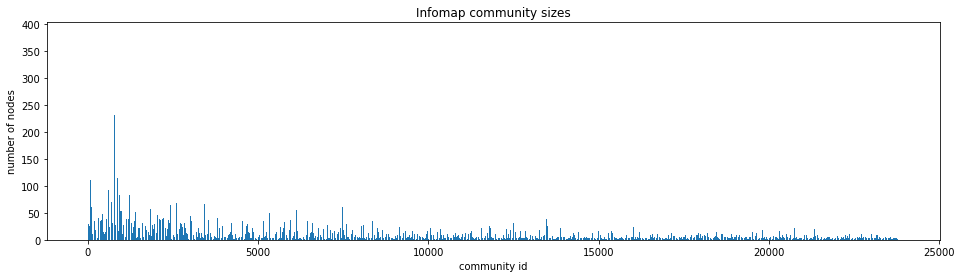

In [102]:
infomap_sizes = c_infomap.sizes()
#infomap_sizes.sort(reverse=True)
plt.figure(figsize=(16,4))
plt.title("Infomap community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(infomap_sizes) + 1)), infomap_sizes)
plt.show()

plot the distribution (historgram) of community sizes

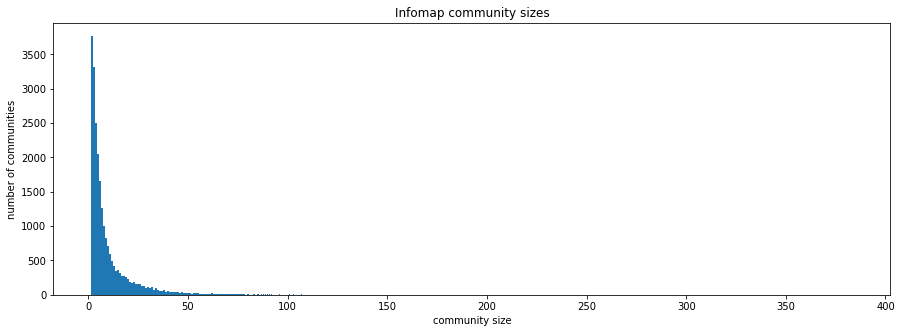

In [101]:
infomap_sizes = c_infomap.sizes()

infomap_hist = []
for i in range(min(infomap_sizes), max(infomap_sizes)):
    count = infomap_sizes.count(i)
    infomap_hist.append(count)
    
#infomap_sizes.sort(reverse=True)
plt.figure(figsize=(15,5))
plt.title("Infomap community sizes")
plt.xlabel("community size")
plt.ylabel("number of communities")
plt.bar(list(range(min(infomap_sizes), max(infomap_sizes))), infomap_hist)
plt.show()

## Store node community membership

Create Dictionary of Infomap community membership for later comparisons with GraphSAGE clustering

In [17]:
infomap_com_dict = dict(zip(list(G_nx.nodes()), c_infomap.membership))

infomap_com_dict #prints dictionary of {node:community id}

### Visualizing a single community cluster
apply Infomap membership to original networkx Graph as a node attribute

In [103]:
nx.set_node_attributes(G_nx, infomap_com_dict, "c_infomap")

In [119]:
com_id = 100 # select the community id

# extraction of a subgraph from the nodes in this community
com_g = G_nx.subgraph(
    [n for n, attrdict in G_nx.nodes.items() if attrdict["c_infomap"] == com_id]
)
print(nx.info(com_g))

Graph with 16 nodes and 43 edges


Creating label dictionaries for community structure plot

In [120]:
name_labels = nx.get_node_attributes(com_g, 'Name')
country_labels = nx.get_node_attributes(com_g, 'Country')
labels_combined = {}
for i in name_labels:
    labels_combined[i] = str(name_labels[i]) + "\n" + str(country_labels[i])

Plotting the community

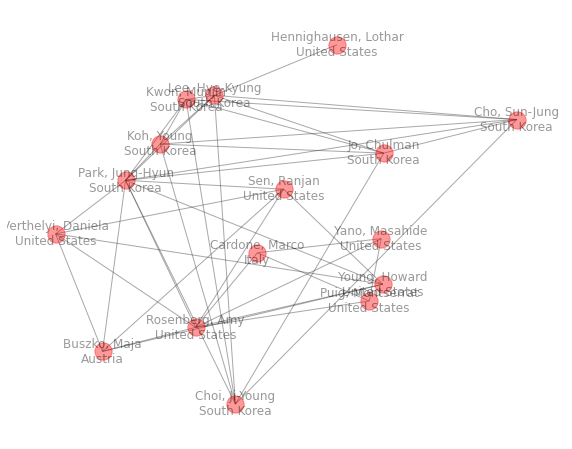

In [125]:
# plot community structure only
pos = nx.random_layout(com_g, seed=123)
plt.figure(figsize=(10, 8))
nx.draw_networkx(com_g, pos, edge_color="#26282b", node_color="red", alpha=0.4, labels=labels_combined)
plt.axis("off")
plt.show()

# Unsupervised GraphSAGE Analysis

In [18]:
import os
import numpy as np
from tensorflow import keras

from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

### Arranging *node* data for StellarGraph graph creation
can use the same `note_data` dataframe from above, but need to eliminate all non-numerical data

replace dataframe's numerical index with authorIDs

In [17]:
display(node_data)

,Name,Country,PubNum
88687508,"Antinori, A",Italy,1
88660066,"Notari, S",Italy,1
88693999,"Cicalini, Stefania",Italy,2
88696885,"Agrati, Chiara",Italy,12
88696886,"Campioni, Paolo",Italy,2
...,...,...,...
88698404,"Richardson, Candice",Canada,1
88698369,"Phillips, Suzanne",Canada,1
88693867,"Patton, Megan",Canada,1
88698475,"Sass, Nelson",Brazil,1


Drop non-numerical data (only numerical data can be used as graph features/attributes)

In [20]:
node_data_sg = node_data.drop(columns = ['Name','Country'])
display(node_data_sg)

,PubNum
88687508,1
88660066,1
88693999,2
88696885,12
88696886,2
...,...
88698404,1
88698369,1
88693867,1
88698475,1


### Arranging *edge* data for GraphSAGE graph creation
We can use the edgelist created above, but need to do a little more tweaking: isolate source and target with the numerical edge feature/attribute: AuthorNum (total number of (co)authors on each collaborative publication)

In [21]:
edge_data = coAuthorNetworkEdgeList.drop(columns = ['Name','Country','PubNum'])
display(edge_data)

,Authorid,AuthorNum,Coauthorid
0,88687508,13,88660066
1,88687508,13,88693999
2,88687508,13,88696885
3,88687508,13,88696886
4,88687508,13,88693998
...,...,...,...
4615043,88698076,2,88694600
4615044,88697601,2,88696152
4615045,88696152,2,88697601
4615046,88698475,2,88698378


Rearrange columns and rename 'Authorid' to 'source' and 'Coauthorid' to 'target' (a GraphSAGE convention for graph creation)

In [22]:
edge_data = edge_data[['Authorid','Coauthorid','AuthorNum']]
edge_data_sg = edge_data.rename(columns={"Authorid": "source", "Coauthorid": "target"})
display(edge_data_sg)

,source,target,AuthorNum
0,88687508,88660066,13
1,88687508,88693999,13
2,88687508,88696885,13
3,88687508,88696886,13
4,88687508,88693998,13
...,...,...,...
4615043,88698076,88694600,2
4615044,88697601,88696152,2
4615045,88696152,88697601,2
4615046,88698475,88698378,2


### Create a Graph from these two node_data and edge_data dataframes
with named node type ("coauthor") and edge type ("collaboration")

In [23]:
G_named_features = StellarGraph(
    {"coauthor": node_data_sg}, {"collaboration": edge_data_sg}
)
print(G_named_features.info())

StellarGraph: Undirected multigraph
 Nodes: 260637, Edges: 4615048

 Node types:
  coauthor: [260637]
    Features: float32 vector, length 1
    Edge types: coauthor-collaboration->coauthor

 Edge types:
    coauthor-collaboration->coauthor: [4615048]
        Weights: all 1 (default)
        Features: float32 vector, length 1


# GraphSAGE Node Embedding

set parameters

In [24]:
nodes = list(G_named_features.nodes())
number_of_walks = 1
length = 5

In [25]:
unsupervised_samples = UnsupervisedSampler(
    G_named_features, nodes=nodes, length=length, number_of_walks=number_of_walks
)

Create a node pair generator

In [26]:
batch_size = 50
epochs = 4
num_samples = [10, 5]

"In the following we show the working of node pair generator with the UnsupervisedSampler, which will generate samples on demand."

In [27]:
generator = GraphSAGELinkGenerator(G_named_features, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

"Build the model: a 2-layer GraphSAGE encoder acting as node representation learner, with a link classification layer on concatenated (citing-paper, cited-paper) node embeddings."

In [28]:
layer_sizes = [50, 50]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [29]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

2021-12-05 15:55:58.295937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


"Final node pair classification layer that takes a pair of nodes’ embeddings produced by `graphsage` encoder, applies a binary operator to them to produce the corresponding node pair embedding (`ip` for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:"

In [30]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


"Stack the GraphSAGE encoder and prediction layer into a Keras model, and specify the loss"

In [31]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

### Train the model

(from newer demo)

(from older demo)

In [32]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

2021-12-05 15:55:59.604481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
41702/41702 - 1718s - loss: 0.5731 - binary_accuracy: 0.7302
Epoch 2/4
41702/41702 - 1714s - loss: 0.5661 - binary_accuracy: 0.7423
Epoch 3/4
41702/41702 - 1714s - loss: 0.5646 - binary_accuracy: 0.7483
Epoch 4/4
41702/41702 - 1703s - loss: 0.5645 - binary_accuracy: 0.7489


### Extracting node embeddings

"Now that the node pair classifier is trained, we can use its node encoder part as node embeddings evaluator. Below we evaluate node embeddings as activations of the output of GraphSAGE layer stack, and visualise them, coloring nodes by their subject label."

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator

%matplotlib inline

### Building a new node-based model

"The `(src, dst)` node pair classifier model has two identical node encoders: one for source nodes in the node pairs, the other for destination nodes in the node pairs passed to the model. We can use either of the two identical encoders to evaluate node embeddings. 

Below we create an embedding model by defining a new Keras model with `x_inp_src` (a list of odd elements in `x_inp`) and `x_out_src` (the 1st element in `x_out`) as input and output, respectively. Note that this model’s weights are the same as those of the corresponding node encoder in the previously trained node pair classifier."



In [34]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

"We also need a node generator to feed graph nodes to `embedding_model.` We want to evaluate node embeddings for all nodes in the graph:"

In [35]:
node_ids = list(G_named_features.nodes())
node_gen = GraphSAGENodeGenerator(G_named_features, batch_size, num_samples).flow(node_ids)

We now use `node_gen` to feed all nodes into the embedding model and extract their embeddings:

In [36]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

5213/5213 [==============================] - 232s 44ms/step


save node embeddings to avoid re-running later

In [68]:
np.savetxt('node_embeddings.txt',node_embeddings)

## Visualize the node embeddings
### 2D t-sne plot of the resulting node embeddings
Here we visually check whether embeddings have some underlying cluster structure.

In [39]:
print(node_embeddings.shape)

(260637, 50)

Run t-SNE dimension reduction

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


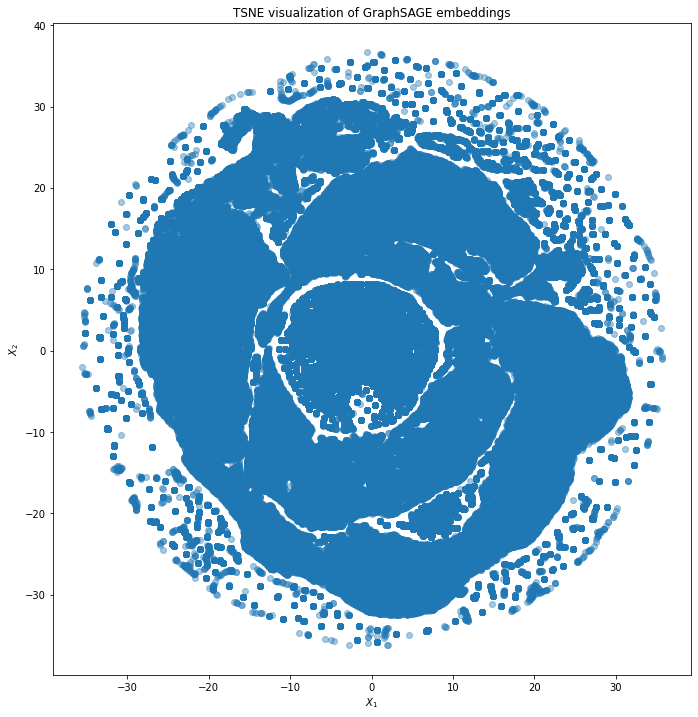

In [40]:
X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2, random_state=1)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})

save t-SNE embeddings to avoid rerunning later

In [60]:
emb_transformed.to_csv('emb_transformed.csv')

Create scatterplot

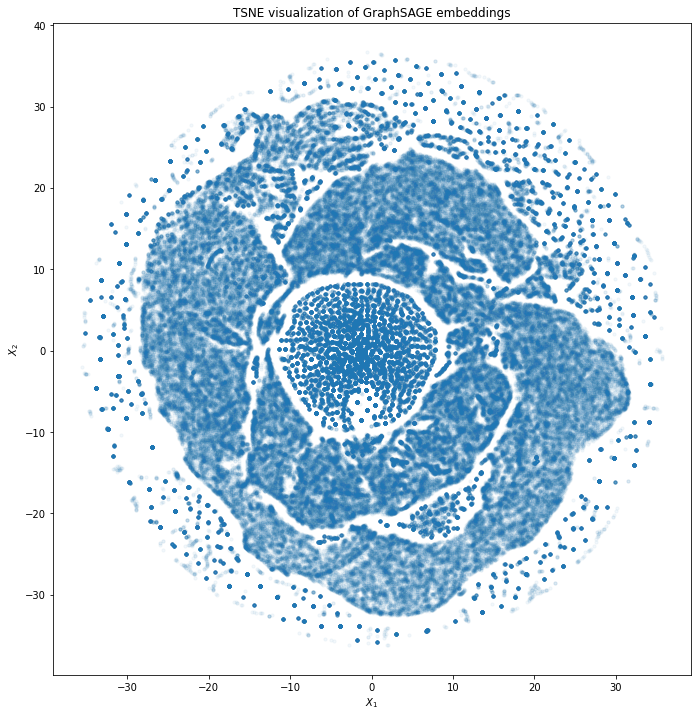

In [55]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    emb_transformed[0], 
    emb_transformed[1], 
    alpha=0.05,
    s=10
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("{} visualization of GraphSAGE embeddings".format(transform.__name__))
plt.show()

## t-SNE Colored by Infomap Community Membership

We also depict the same t-sne plot colored by infomap communities. As we can observe t-sne of GraphSAGE embeddings do not really separate the infomap communities.

Text(0.5, 1.0, 't-sne with colors corresponding to infomap communities')

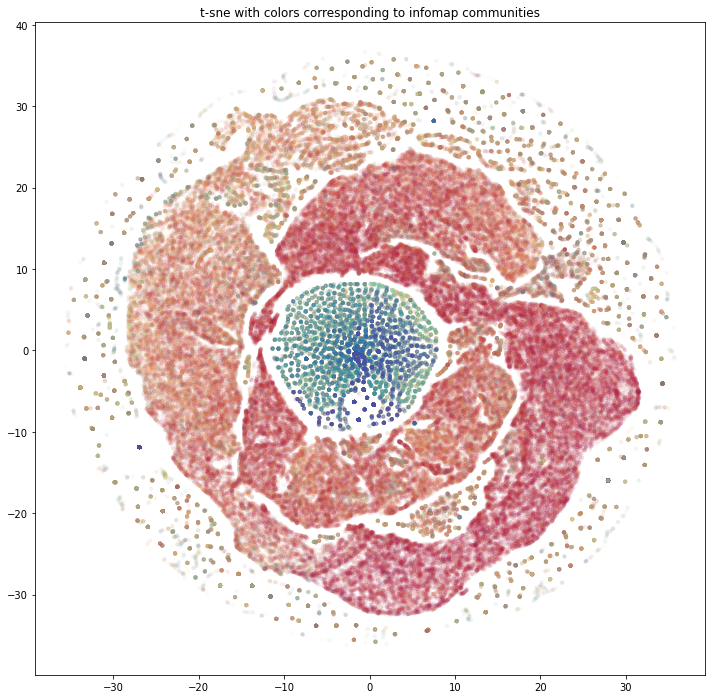

In [69]:
emb_transformed["infomap_clusters"] = emb_transformed.index.map(infomap_com_dict)
plt.figure(figsize=(12,12))
plt.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["infomap_clusters"],
    cmap="Spectral",
    edgecolors=None,
    alpha=0.05,
    s=10,
)
plt.title("t-sne with colors corresponding to infomap communities")